In [6]:
import openai 
from langchain.text_splitter import CharacterTextSplitter


In [73]:
# from google.colab import drive
# drive.mount('/content/drive')

apipath = r'H:\\My Drive\\config\\hbqa.txt'
import configparser

config = configparser.ConfigParser()
config.read(apipath)
secret_key = config['global']['OPENAI_API_KEY']
datapath = config['global']['DATA_FOLDER']
corpuspath = config['global']['CORPUS_FOLDER']
 

In [108]:
import pandas as pd 
df = pd.read_csv(datapath+'01.1-Mahabharat_Metadata.csv')
df.head(3)

,Book_Id,Book_Name,Section_Id,File_Name,URL,Section_Roman,Section_Word_Count,Section_Letter_Count,Section_Para_Count,Avg_Word_Len
0,1,Book 1: Adi Parva,Book01_002,mahabharata_01002.txt,https://www.mahabharataonline.com/translation/...,Section I,7464,44206,45,5.92
1,2,Book 1: Adi Parva,Book01_003,mahabharata_01003.txt,https://www.mahabharataonline.com/translation/...,Section II,8608,52123,33,6.06
2,3,Book 1: Adi Parva,Book01_004,mahabharata_01004.txt,https://www.mahabharataonline.com/translation/...,Section III,6089,35041,48,5.75


# Create Chunk for Prompt Creation
- If we do not split and create chunk then ChatGPT cannot handle it. Secondly it will be more costly.
- These chunk should be used to to creating ChatGPT QA prompt.

In [109]:
def Create_Chunks(df1, df_chunks, idx_of_files, chunk_id):
    for i in idx_of_files:
        section_file_name = df1.loc[i,"File_Name"]
        section_id = df1.loc[i, "Section_Id"]
        Section_Word_Count = df1.loc[i, "Section_Word_Count"] 
        Section_Letter_Count = df1.loc[i,"Section_Letter_Count"]
        #question_to_generate = df1.loc[i,"Questions"]

        print ("File:",section_file_name,
                '| Sectionid:', section_id,
                "| Section Words Count:", Section_Word_Count, 
                "| Section Letter Count:",Section_Letter_Count,
                #'| Questions:',question_to_generate
                )
            
            
        section_file_path = corpuspath+ section_file_name
        with open(section_file_path, "r") as file_section:
            text = file_section.readlines()
            text = "\n".join(text)
            # text = text.replace('\n\n \n\n', '\n')

        # split into chunks
        text_splitter = CharacterTextSplitter(
            separator="\n",
            chunk_size=8000,
            chunk_overlap=300,
            length_function=len
        )
                        
        chunks = text_splitter.split_text(text)
        for chunk in chunks: 
            new_row = section_id, chunk_id, chunk 
            df_chunks.loc[chunk_id] = new_row
            chunk_id = chunk_id +1

    return chunk_id, df_chunks


In [110]:
# Initialize dataset for prompt 
df_chunks = pd.DataFrame(columns=['Section_Id','Chunk_Id','Chunk'])
# Initialize context_id
chunk_id = 1 

# Generate Questions & Answers for Sections.
idx_of_files = df.index
chunk_id, df_chunks = Create_Chunks(df, df_chunks, idx_of_files, chunk_id)
print(f"{chunk_id} Chunks Generated")


Created a chunk of size 10832, which is longer than the specified 8000


File: mahabharata_01002.txt | Sectionid: Book01_002 | Section Words Count: 7464 | Section Letter Count: 44206
File: mahabharata_01003.txt | Sectionid: Book01_003 | Section Words Count: 8608 | Section Letter Count: 52123
File: mahabharata_01004.txt | Sectionid: Book01_004 | Section Words Count: 6089 | Section Letter Count: 35041
File: mahabharata_01005.txt | Sectionid: Book01_005 | Section Words Count: 341 | Section Letter Count: 1991
File: mahabharata_01006.txt | Sectionid: Book01_006 | Section Words Count: 876 | Section Letter Count: 5068
File: mahabharata_01007.txt | Sectionid: Book01_007 | Section Words Count: 403 | Section Letter Count: 2272
File: mahabharata_01008.txt | Sectionid: Book01_008 | Section Words Count: 896 | Section Letter Count: 5098
File: mahabharata_01009.txt | Sectionid: Book01_009 | Section Words Count: 642 | Section Letter Count: 3777
File: mahabharata_01010.txt | Sectionid: Book01_010 | Section Words Count: 641 | Section Letter Count: 3638
File: mahabharata_0101

Created a chunk of size 10810, which is longer than the specified 8000


File: mahabharata_01076.txt | Sectionid: Book01_076 | Section Words Count: 1461 | Section Letter Count: 8564
File: mahabharata_01077.txt | Sectionid: Book01_077 | Section Words Count: 2244 | Section Letter Count: 12891
File: mahabharata_01078.txt | Sectionid: Book01_078 | Section Words Count: 655 | Section Letter Count: 3771
File: mahabharata_01079.txt | Sectionid: Book01_079 | Section Words Count: 1168 | Section Letter Count: 6786
File: mahabharata_01080.txt | Sectionid: Book01_080 | Section Words Count: 368 | Section Letter Count: 2184
File: mahabharata_01081.txt | Sectionid: Book01_081 | Section Words Count: 749 | Section Letter Count: 4509
File: mahabharata_01082.txt | Sectionid: Book01_082 | Section Words Count: 1030 | Section Letter Count: 6010
File: mahabharata_01083.txt | Sectionid: Book01_083 | Section Words Count: 799 | Section Letter Count: 4575
File: mahabharata_01084.txt | Sectionid: Book01_084 | Section Words Count: 1140 | Section Letter Count: 6587
File: mahabharata_0108

Created a chunk of size 16668, which is longer than the specified 8000
Created a chunk of size 9381, which is longer than the specified 8000


File: mahabharata_02006.txt | Sectionid: Book02_006 | Section Words Count: 572 | Section Letter Count: 3482
File: mahabharata_02007.txt | Sectionid: Book02_007 | Section Words Count: 765 | Section Letter Count: 4693
File: mahabharata_02008.txt | Sectionid: Book02_008 | Section Words Count: 894 | Section Letter Count: 5719
File: mahabharata_02009.txt | Sectionid: Book02_009 | Section Words Count: 677 | Section Letter Count: 4217
File: mahabharata_02010.txt | Sectionid: Book02_010 | Section Words Count: 900 | Section Letter Count: 5808
File: mahabharata_02011.txt | Sectionid: Book02_011 | Section Words Count: 1416 | Section Letter Count: 8664
File: mahabharata_02012.txt | Sectionid: Book02_012 | Section Words Count: 979 | Section Letter Count: 5582
File: mahabharata_02013.txt | Sectionid: Book02_013 | Section Words Count: 1504 | Section Letter Count: 9293
File: mahabharata_02014.txt | Sectionid: Book02_014 | Section Words Count: 1915 | Section Letter Count: 11208
File: mahabharata_02015.

Created a chunk of size 9897, which is longer than the specified 8000
Created a chunk of size 10162, which is longer than the specified 8000


File: mahabharata_03012.txt | Sectionid: Book03_012 | Section Words Count: 3504 | Section Letter Count: 20236
File: mahabharata_03013.txt | Sectionid: Book03_013 | Section Words Count: 446 | Section Letter Count: 2473
File: mahabharata_03014.txt | Sectionid: Book03_014 | Section Words Count: 598 | Section Letter Count: 3305
File: mahabharata_03015.txt | Sectionid: Book03_015 | Section Words Count: 560 | Section Letter Count: 3336
File: mahabharata_03016.txt | Sectionid: Book03_016 | Section Words Count: 785 | Section Letter Count: 4632
File: mahabharata_03017.txt | Sectionid: Book03_017 | Section Words Count: 616 | Section Letter Count: 3550
File: mahabharata_03018.txt | Sectionid: Book03_018 | Section Words Count: 907 | Section Letter Count: 4930
File: mahabharata_03019.txt | Sectionid: Book03_019 | Section Words Count: 691 | Section Letter Count: 3926
File: mahabharata_03020.txt | Sectionid: Book03_020 | Section Words Count: 1072 | Section Letter Count: 5950
File: mahabharata_03021.t

Created a chunk of size 8639, which is longer than the specified 8000
Created a chunk of size 18774, which is longer than the specified 8000
Created a chunk of size 11551, which is longer than the specified 8000


File: mahabharata_03054.txt | Sectionid: Book03_054 | Section Words Count: 733 | Section Letter Count: 4334
File: mahabharata_03055.txt | Sectionid: Book03_055 | Section Words Count: 640 | Section Letter Count: 3634
File: mahabharata_03056.txt | Sectionid: Book03_056 | Section Words Count: 664 | Section Letter Count: 3693
File: mahabharata_03057.txt | Sectionid: Book03_057 | Section Words Count: 1123 | Section Letter Count: 6578
File: mahabharata_03058.txt | Sectionid: Book03_058 | Section Words Count: 363 | Section Letter Count: 2130
File: mahabharata_03059.txt | Sectionid: Book03_059 | Section Words Count: 431 | Section Letter Count: 2546
File: mahabharata_03060.txt | Sectionid: Book03_060 | Section Words Count: 554 | Section Letter Count: 3215
File: mahabharata_03061.txt | Sectionid: Book03_061 | Section Words Count: 886 | Section Letter Count: 4953
File: mahabharata_03062.txt | Sectionid: Book03_062 | Section Words Count: 726 | Section Letter Count: 4053
File: mahabharata_03063.txt

Created a chunk of size 10646, which is longer than the specified 8000
Created a chunk of size 8495, which is longer than the specified 8000


File: mahabharata_03143.txt | Sectionid: Book03_143 | Section Words Count: 714 | Section Letter Count: 4273
File: mahabharata_03144.txt | Sectionid: Book03_144 | Section Words Count: 1251 | Section Letter Count: 7846
File: mahabharata_03145.txt | Sectionid: Book03_145 | Section Words Count: 2380 | Section Letter Count: 13825
File: mahabharata_03146.txt | Sectionid: Book03_146 | Section Words Count: 901 | Section Letter Count: 4935
File: mahabharata_03147.txt | Sectionid: Book03_147 | Section Words Count: 511 | Section Letter Count: 2937
File: mahabharata_03148.txt | Sectionid: Book03_148 | Section Words Count: 1098 | Section Letter Count: 6380
File: mahabharata_03149.txt | Sectionid: Book03_149 | Section Words Count: 1419 | Section Letter Count: 8676
File: mahabharata_03150.txt | Sectionid: Book03_150 | Section Words Count: 466 | Section Letter Count: 2571
File: mahabharata_03151.txt | Sectionid: Book03_151 | Section Words Count: 328 | Section Letter Count: 2003
File: mahabharata_03152

Created a chunk of size 8097, which is longer than the specified 8000
Created a chunk of size 8213, which is longer than the specified 8000
Created a chunk of size 8013, which is longer than the specified 8000


File: mahabharata_03183.txt | Sectionid: Book03_183 | Section Words Count: 594 | Section Letter Count: 3344
File: mahabharata_03184.txt | Sectionid: Book03_184 | Section Words Count: 1012 | Section Letter Count: 5985
File: mahabharata_03185.txt | Sectionid: Book03_185 | Section Words Count: 606 | Section Letter Count: 3560
File: mahabharata_03186.txt | Sectionid: Book03_186 | Section Words Count: 1351 | Section Letter Count: 7350
File: mahabharata_03187.txt | Sectionid: Book03_187 | Section Words Count: 3852 | Section Letter Count: 21877
File: mahabharata_03188.txt | Sectionid: Book03_188 | Section Words Count: 1740 | Section Letter Count: 9624
File: mahabharata_03189.txt | Sectionid: Book03_189 | Section Words Count: 2788 | Section Letter Count: 15748
File: mahabharata_03190.txt | Sectionid: Book03_190 | Section Words Count: 1022 | Section Letter Count: 6028
File: mahabharata_03191.txt | Sectionid: Book03_191 | Section Words Count: 2756 | Section Letter Count: 15405
File: mahabharata_

Created a chunk of size 11989, which is longer than the specified 8000
Created a chunk of size 9097, which is longer than the specified 8000


File: mahabharata_03271.txt | Sectionid: Book03_271 | Section Words Count: 369 | Section Letter Count: 2137
File: mahabharata_03272.txt | Sectionid: Book03_272 | Section Words Count: 454 | Section Letter Count: 2647
File: mahabharata_03273.txt | Sectionid: Book03_273 | Section Words Count: 981 | Section Letter Count: 5999
File: mahabharata_03274.txt | Sectionid: Book03_274 | Section Words Count: 391 | Section Letter Count: 2319
File: mahabharata_03275.txt | Sectionid: Book03_275 | Section Words Count: 1503 | Section Letter Count: 8789
File: mahabharata_03276.txt | Sectionid: Book03_276 | Section Words Count: 1131 | Section Letter Count: 6355
File: mahabharata_03277.txt | Sectionid: Book03_277 | Section Words Count: 1362 | Section Letter Count: 7692
File: mahabharata_03278.txt | Sectionid: Book03_278 | Section Words Count: 1963 | Section Letter Count: 11255
File: mahabharata_03279.txt | Sectionid: Book03_279 | Section Words Count: 815 | Section Letter Count: 4631
File: mahabharata_03280

Created a chunk of size 9146, which is longer than the specified 8000
Created a chunk of size 10310, which is longer than the specified 8000


File: mahabharata_05056.txt | Sectionid: Book05_056 | Section Words Count: 563 | Section Letter Count: 3305
File: mahabharata_05057.txt | Sectionid: Book05_057 | Section Words Count: 1518 | Section Letter Count: 9184
File: mahabharata_05058.txt | Sectionid: Book05_058 | Section Words Count: 776 | Section Letter Count: 4524
File: mahabharata_05059.txt | Sectionid: Book05_059 | Section Words Count: 776 | Section Letter Count: 4557
File: mahabharata_05060.txt | Sectionid: Book05_060 | Section Words Count: 594 | Section Letter Count: 3409
File: mahabharata_05061.txt | Sectionid: Book05_061 | Section Words Count: 705 | Section Letter Count: 4087
File: mahabharata_05062.txt | Sectionid: Book05_062 | Section Words Count: 616 | Section Letter Count: 3644
File: mahabharata_05063.txt | Sectionid: Book05_063 | Section Words Count: 677 | Section Letter Count: 4054
File: mahabharata_05064.txt | Sectionid: Book05_064 | Section Words Count: 701 | Section Letter Count: 4054
File: mahabharata_05065.txt

Created a chunk of size 8069, which is longer than the specified 8000


File: mahabharata_05117.txt | Sectionid: Book05_117 | Section Words Count: 453 | Section Letter Count: 2726
File: mahabharata_05118.txt | Sectionid: Book05_118 | Section Words Count: 552 | Section Letter Count: 3104
File: mahabharata_05119.txt | Sectionid: Book05_119 | Section Words Count: 639 | Section Letter Count: 3660
File: mahabharata_05120.txt | Sectionid: Book05_120 | Section Words Count: 526 | Section Letter Count: 3191
File: mahabharata_05121.txt | Sectionid: Book05_121 | Section Words Count: 869 | Section Letter Count: 5026
File: mahabharata_05122.txt | Sectionid: Book05_122 | Section Words Count: 483 | Section Letter Count: 2841
File: mahabharata_05123.txt | Sectionid: Book05_123 | Section Words Count: 683 | Section Letter Count: 4051
File: mahabharata_05124.txt | Sectionid: Book05_124 | Section Words Count: 1806 | Section Letter Count: 10697
File: mahabharata_05125.txt | Sectionid: Book05_125 | Section Words Count: 754 | Section Letter Count: 4453
File: mahabharata_05126.tx

Created a chunk of size 8609, which is longer than the specified 8000


File: mahabharata_05172.txt | Sectionid: Book05_172 | Section Words Count: 682 | Section Letter Count: 4087
File: mahabharata_05173.txt | Sectionid: Book05_173 | Section Words Count: 575 | Section Letter Count: 3354
File: mahabharata_05174.txt | Sectionid: Book05_174 | Section Words Count: 581 | Section Letter Count: 3396
File: mahabharata_05175.txt | Sectionid: Book05_175 | Section Words Count: 264 | Section Letter Count: 1549
File: mahabharata_05176.txt | Sectionid: Book05_176 | Section Words Count: 715 | Section Letter Count: 3961
File: mahabharata_05177.txt | Sectionid: Book05_177 | Section Words Count: 533 | Section Letter Count: 3032
File: mahabharata_05178.txt | Sectionid: Book05_178 | Section Words Count: 1557 | Section Letter Count: 9022
File: mahabharata_05179.txt | Sectionid: Book05_179 | Section Words Count: 1145 | Section Letter Count: 6466
File: mahabharata_05180.txt | Sectionid: Book05_180 | Section Words Count: 648 | Section Letter Count: 3691
File: mahabharata_05181.tx

Created a chunk of size 21415, which is longer than the specified 8000


File: mahabharata_06029.txt | Sectionid: Book06_029 | Section Words Count: 858 | Section Letter Count: 5112
File: mahabharata_06030.txt | Sectionid: Book06_030 | Section Words Count: 1414 | Section Letter Count: 8114
File: mahabharata_06031.txt | Sectionid: Book06_031 | Section Words Count: 846 | Section Letter Count: 4766
File: mahabharata_06032.txt | Sectionid: Book06_032 | Section Words Count: 817 | Section Letter Count: 4764
File: mahabharata_06033.txt | Sectionid: Book06_033 | Section Words Count: 961 | Section Letter Count: 5553
File: mahabharata_06034.txt | Sectionid: Book06_034 | Section Words Count: 1125 | Section Letter Count: 6323
File: mahabharata_06035.txt | Sectionid: Book06_035 | Section Words Count: 1775 | Section Letter Count: 10242
File: mahabharata_06036.txt | Sectionid: Book06_036 | Section Words Count: 569 | Section Letter Count: 3337
File: mahabharata_06037.txt | Sectionid: Book06_037 | Section Words Count: 820 | Section Letter Count: 4889
File: mahabharata_06038.

Created a chunk of size 8061, which is longer than the specified 8000


File: mahabharata_06078.txt | Sectionid: Book06_078 | Section Words Count: 374 | Section Letter Count: 2292
File: mahabharata_06079.txt | Sectionid: Book06_079 | Section Words Count: 479 | Section Letter Count: 2815
File: mahabharata_06080.txt | Sectionid: Book06_080 | Section Words Count: 1497 | Section Letter Count: 9144
File: mahabharata_06081.txt | Sectionid: Book06_081 | Section Words Count: 652 | Section Letter Count: 3877
File: mahabharata_06082.txt | Sectionid: Book06_082 | Section Words Count: 1095 | Section Letter Count: 6708
File: mahabharata_06083.txt | Sectionid: Book06_083 | Section Words Count: 1583 | Section Letter Count: 9498
File: mahabharata_06084.txt | Sectionid: Book06_084 | Section Words Count: 1428 | Section Letter Count: 8544
File: mahabharata_06085.txt | Sectionid: Book06_085 | Section Words Count: 1264 | Section Letter Count: 7598
File: mahabharata_06086.txt | Sectionid: Book06_086 | Section Words Count: 1288 | Section Letter Count: 7828
File: mahabharata_0608

Created a chunk of size 8355, which is longer than the specified 8000


File: mahabharata_06118.txt | Sectionid: Book06_118 | Section Words Count: 1430 | Section Letter Count: 8830
File: mahabharata_06119.txt | Sectionid: Book06_119 | Section Words Count: 1204 | Section Letter Count: 7381
File: mahabharata_06120.txt | Sectionid: Book06_120 | Section Words Count: 2991 | Section Letter Count: 17747
File: mahabharata_06121.txt | Sectionid: Book06_121 | Section Words Count: 928 | Section Letter Count: 5453
File: mahabharata_06122.txt | Sectionid: Book06_122 | Section Words Count: 851 | Section Letter Count: 5100
File: mahabharata_06123.txt | Sectionid: Book06_123 | Section Words Count: 1458 | Section Letter Count: 8553
File: mahabharata_06124.txt | Sectionid: Book06_124 | Section Words Count: 841 | Section Letter Count: 4701
File: mahabharata_07001.txt | Sectionid: Book07_001 | Section Words Count: 1356 | Section Letter Count: 7982
File: mahabharata_07002.txt | Sectionid: Book07_002 | Section Words Count: 1479 | Section Letter Count: 8708
File: mahabharata_070

Created a chunk of size 8132, which is longer than the specified 8000


File: mahabharata_07031.txt | Sectionid: Book07_031 | Section Words Count: 814 | Section Letter Count: 4774
File: mahabharata_07032.txt | Sectionid: Book07_032 | Section Words Count: 621 | Section Letter Count: 3704
File: mahabharata_07033.txt | Sectionid: Book07_033 | Section Words Count: 729 | Section Letter Count: 4464
File: mahabharata_07034.txt | Sectionid: Book07_034 | Section Words Count: 1342 | Section Letter Count: 8122
File: mahabharata_07035.txt | Sectionid: Book07_035 | Section Words Count: 961 | Section Letter Count: 5864
File: mahabharata_07036.txt | Sectionid: Book07_036 | Section Words Count: 587 | Section Letter Count: 3537
File: mahabharata_07037.txt | Sectionid: Book07_037 | Section Words Count: 1818 | Section Letter Count: 10816
File: mahabharata_07038.txt | Sectionid: Book07_038 | Section Words Count: 679 | Section Letter Count: 4102
File: mahabharata_07039.txt | Sectionid: Book07_039 | Section Words Count: 634 | Section Letter Count: 3867
File: mahabharata_07040.t

Created a chunk of size 10695, which is longer than the specified 8000


File: mahabharata_07063.txt | Sectionid: Book07_063 | Section Words Count: 579 | Section Letter Count: 3441
File: mahabharata_07064.txt | Sectionid: Book07_064 | Section Words Count: 591 | Section Letter Count: 3395
File: mahabharata_07065.txt | Sectionid: Book07_065 | Section Words Count: 504 | Section Letter Count: 3027
File: mahabharata_07066.txt | Sectionid: Book07_066 | Section Words Count: 976 | Section Letter Count: 5615
File: mahabharata_07067.txt | Sectionid: Book07_067 | Section Words Count: 615 | Section Letter Count: 3674
File: mahabharata_07068.txt | Sectionid: Book07_068 | Section Words Count: 799 | Section Letter Count: 4714
File: mahabharata_07069.txt | Sectionid: Book07_069 | Section Words Count: 2309 | Section Letter Count: 13379
File: mahabharata_07070.txt | Sectionid: Book07_070 | Section Words Count: 1294 | Section Letter Count: 7509
File: mahabharata_07071.txt | Sectionid: Book07_071 | Section Words Count: 932 | Section Letter Count: 5458
File: mahabharata_07072.t

Created a chunk of size 9761, which is longer than the specified 8000
Created a chunk of size 9843, which is longer than the specified 8000
Created a chunk of size 8637, which is longer than the specified 8000


File: mahabharata_07125.txt | Sectionid: Book07_125 | Section Words Count: 847 | Section Letter Count: 5064
File: mahabharata_07126.txt | Sectionid: Book07_126 | Section Words Count: 1082 | Section Letter Count: 6547
File: mahabharata_07127.txt | Sectionid: Book07_127 | Section Words Count: 1373 | Section Letter Count: 8225
File: mahabharata_07128.txt | Sectionid: Book07_128 | Section Words Count: 1091 | Section Letter Count: 6403
File: mahabharata_07129.txt | Sectionid: Book07_129 | Section Words Count: 1135 | Section Letter Count: 6652
File: mahabharata_07130.txt | Sectionid: Book07_130 | Section Words Count: 823 | Section Letter Count: 4979
File: mahabharata_07131.txt | Sectionid: Book07_131 | Section Words Count: 967 | Section Letter Count: 5771
File: mahabharata_07132.txt | Sectionid: Book07_132 | Section Words Count: 941 | Section Letter Count: 5596
File: mahabharata_07133.txt | Sectionid: Book07_133 | Section Words Count: 1322 | Section Letter Count: 7748
File: mahabharata_07134

Created a chunk of size 14883, which is longer than the specified 8000


File: mahabharata_07184.txt | Sectionid: Book07_184 | Section Words Count: 1251 | Section Letter Count: 7761
File: mahabharata_07185.txt | Sectionid: Book07_185 | Section Words Count: 1335 | Section Letter Count: 7913
File: mahabharata_07186.txt | Sectionid: Book07_186 | Section Words Count: 1646 | Section Letter Count: 9984
File: mahabharata_07187.txt | Sectionid: Book07_187 | Section Words Count: 1513 | Section Letter Count: 9171
File: mahabharata_07188.txt | Sectionid: Book07_188 | Section Words Count: 1395 | Section Letter Count: 8433
File: mahabharata_07189.txt | Sectionid: Book07_189 | Section Words Count: 2108 | Section Letter Count: 12552
File: mahabharata_07190.txt | Sectionid: Book07_190 | Section Words Count: 1705 | Section Letter Count: 10226
File: mahabharata_07191.txt | Sectionid: Book07_191 | Section Words Count: 393 | Section Letter Count: 2362
File: mahabharata_07192.txt | Sectionid: Book07_192 | Section Words Count: 1238 | Section Letter Count: 7165
File: mahabharata_

Created a chunk of size 9650, which is longer than the specified 8000
Created a chunk of size 8889, which is longer than the specified 8000


File: mahabharata_08014.txt | Sectionid: Book08_014 | Section Words Count: 873 | Section Letter Count: 5427
File: mahabharata_08015.txt | Sectionid: Book08_015 | Section Words Count: 1139 | Section Letter Count: 6672
File: mahabharata_08016.txt | Sectionid: Book08_016 | Section Words Count: 1439 | Section Letter Count: 8617
File: mahabharata_08017.txt | Sectionid: Book08_017 | Section Words Count: 975 | Section Letter Count: 5851
File: mahabharata_08018.txt | Sectionid: Book08_018 | Section Words Count: 975 | Section Letter Count: 5748
File: mahabharata_08019.txt | Sectionid: Book08_019 | Section Words Count: 1603 | Section Letter Count: 9707
File: mahabharata_08020.txt | Sectionid: Book08_020 | Section Words Count: 1720 | Section Letter Count: 10171
File: mahabharata_08021.txt | Sectionid: Book08_021 | Section Words Count: 1011 | Section Letter Count: 6153
File: mahabharata_08022.txt | Sectionid: Book08_022 | Section Words Count: 836 | Section Letter Count: 5138
File: mahabharata_0802

Created a chunk of size 10651, which is longer than the specified 8000
Created a chunk of size 13014, which is longer than the specified 8000


File: mahabharata_08044.txt | Sectionid: Book08_044 | Section Words Count: 1315 | Section Letter Count: 7670
File: mahabharata_08045.txt | Sectionid: Book08_045 | Section Words Count: 1481 | Section Letter Count: 8696
File: mahabharata_08046.txt | Sectionid: Book08_046 | Section Words Count: 2284 | Section Letter Count: 13766
File: mahabharata_08047.txt | Sectionid: Book08_047 | Section Words Count: 608 | Section Letter Count: 3742
File: mahabharata_08048.txt | Sectionid: Book08_048 | Section Words Count: 1697 | Section Letter Count: 10279
File: mahabharata_08049.txt | Sectionid: Book08_049 | Section Words Count: 2473 | Section Letter Count: 14753
File: mahabharata_08050.txt | Sectionid: Book08_050 | Section Words Count: 1183 | Section Letter Count: 6801
File: mahabharata_08051.txt | Sectionid: Book08_051 | Section Words Count: 2031 | Section Letter Count: 12039
File: mahabharata_08052.txt | Sectionid: Book08_052 | Section Words Count: 1020 | Section Letter Count: 6258
File: mahabharat

Created a chunk of size 9041, which is longer than the specified 8000
Created a chunk of size 15856, which is longer than the specified 8000
Created a chunk of size 12777, which is longer than the specified 8000


File: mahabharata_08071.txt | Sectionid: Book08_071 | Section Words Count: 1007 | Section Letter Count: 5796
File: mahabharata_08072.txt | Sectionid: Book08_072 | Section Words Count: 1091 | Section Letter Count: 6397
File: mahabharata_08073.txt | Sectionid: Book08_073 | Section Words Count: 3152 | Section Letter Count: 18779
File: mahabharata_08074.txt | Sectionid: Book08_074 | Section Words Count: 1341 | Section Letter Count: 7491
File: mahabharata_08075.txt | Sectionid: Book08_075 | Section Words Count: 600 | Section Letter Count: 3748
File: mahabharata_08076.txt | Sectionid: Book08_076 | Section Words Count: 1388 | Section Letter Count: 8258
File: mahabharata_08077.txt | Sectionid: Book08_077 | Section Words Count: 1988 | Section Letter Count: 11856
File: mahabharata_08078.txt | Sectionid: Book08_078 | Section Words Count: 1583 | Section Letter Count: 9400
File: mahabharata_08079.txt | Sectionid: Book08_079 | Section Words Count: 2630 | Section Letter Count: 15638
File: mahabharata

Created a chunk of size 8691, which is longer than the specified 8000
Created a chunk of size 9926, which is longer than the specified 8000


File: mahabharata_08094.txt | Sectionid: Book08_094 | Section Words Count: 2442 | Section Letter Count: 14654
File: mahabharata_08095.txt | Sectionid: Book08_095 | Section Words Count: 398 | Section Letter Count: 2511
File: mahabharata_08096.txt | Sectionid: Book08_096 | Section Words Count: 1249 | Section Letter Count: 7471
File: mahabharata_09001.txt | Sectionid: Book09_001 | Section Words Count: 1356 | Section Letter Count: 8106
File: mahabharata_09002.txt | Sectionid: Book09_002 | Section Words Count: 1720 | Section Letter Count: 9731
File: mahabharata_09003.txt | Sectionid: Book09_003 | Section Words Count: 1595 | Section Letter Count: 9421
File: mahabharata_09004.txt | Sectionid: Book09_004 | Section Words Count: 1369 | Section Letter Count: 7841
File: mahabharata_09005.txt | Sectionid: Book09_005 | Section Words Count: 1386 | Section Letter Count: 8031
File: mahabharata_09006.txt | Sectionid: Book09_006 | Section Words Count: 841 | Section Letter Count: 4935
File: mahabharata_09

Created a chunk of size 9355, which is longer than the specified 8000
Created a chunk of size 9776, which is longer than the specified 8000


File: mahabharata_09049.txt | Sectionid: Book09_049 | Section Words Count: 632 | Section Letter Count: 3970
File: mahabharata_09050.txt | Sectionid: Book09_050 | Section Words Count: 1685 | Section Letter Count: 10227
File: mahabharata_09051.txt | Sectionid: Book09_051 | Section Words Count: 1388 | Section Letter Count: 8038
File: mahabharata_09052.txt | Sectionid: Book09_052 | Section Words Count: 736 | Section Letter Count: 4294
File: mahabharata_09053.txt | Sectionid: Book09_053 | Section Words Count: 711 | Section Letter Count: 4219
File: mahabharata_09054.txt | Sectionid: Book09_054 | Section Words Count: 1042 | Section Letter Count: 6265
File: mahabharata_09055.txt | Sectionid: Book09_055 | Section Words Count: 1102 | Section Letter Count: 6641
File: mahabharata_09056.txt | Sectionid: Book09_056 | Section Words Count: 1205 | Section Letter Count: 6808
File: mahabharata_09057.txt | Sectionid: Book09_057 | Section Words Count: 1748 | Section Letter Count: 10502
File: mahabharata_09

Created a chunk of size 10271, which is longer than the specified 8000


File: mahabharata_12a153.txt | Sectionid: Book12_a153 | Section Words Count: 548 | Section Letter Count: 3300
File: mahabharata_12a154.txt | Sectionid: Book12_a154 | Section Words Count: 551 | Section Letter Count: 3102
File: mahabharata_12a155.txt | Sectionid: Book12_a155 | Section Words Count: 272 | Section Letter Count: 1521
File: mahabharata_12a156.txt | Sectionid: Book12_a156 | Section Words Count: 449 | Section Letter Count: 2624
File: mahabharata_12a157.txt | Sectionid: Book12_a157 | Section Words Count: 1110 | Section Letter Count: 6772
File: mahabharata_12a158.txt | Sectionid: Book12_a158 | Section Words Count: 363 | Section Letter Count: 2335
File: mahabharata_12a159.txt | Sectionid: Book12_a159 | Section Words Count: 1116 | Section Letter Count: 6674
File: mahabharata_12a160.txt | Sectionid: Book12_a160 | Section Words Count: 396 | Section Letter Count: 2472
File: mahabharata_12a161.txt | Sectionid: Book12_a161 | Section Words Count: 749 | Section Letter Count: 4501
File: ma

Created a chunk of size 12113, which is longer than the specified 8000


File: mahabharata_12c037.txt | Sectionid: Book12_c037 | Section Words Count: 1287 | Section Letter Count: 7485
File: mahabharata_12c038.txt | Sectionid: Book12_c038 | Section Words Count: 1539 | Section Letter Count: 8750
File: mahabharata_12c039.txt | Sectionid: Book12_c039 | Section Words Count: 4501 | Section Letter Count: 25977
File: mahabharata_12c040.txt | Sectionid: Book12_c040 | Section Words Count: 3942 | Section Letter Count: 23004
File: mahabharata_12c041.txt | Sectionid: Book12_c041 | Section Words Count: 2066 | Section Letter Count: 11648
File: mahabharata_12c042.txt | Sectionid: Book12_c042 | Section Words Count: 7538 | Section Letter Count: 43542
File: mahabharata_12c043.txt | Sectionid: Book12_c043 | Section Words Count: 2087 | Section Letter Count: 12244
File: mahabharata_12c044.txt | Sectionid: Book12_c044 | Section Words Count: 950 | Section Letter Count: 5672
File: mahabharata_12c045.txt | Sectionid: Book12_c045 | Section Words Count: 1061 | Section Letter Count: 61

Created a chunk of size 8588, which is longer than the specified 8000


File: mahabharata_13a007.txt | Sectionid: Book13_a007 | Section Words Count: 884 | Section Letter Count: 5115
File: mahabharata_13a008.txt | Sectionid: Book13_a008 | Section Words Count: 982 | Section Letter Count: 5683
File: mahabharata_13a009.txt | Sectionid: Book13_a009 | Section Words Count: 869 | Section Letter Count: 4959
File: mahabharata_13a010.txt | Sectionid: Book13_a010 | Section Words Count: 2649 | Section Letter Count: 15248
File: mahabharata_13a011.txt | Sectionid: Book13_a011 | Section Words Count: 920 | Section Letter Count: 5264
File: mahabharata_13a012.txt | Sectionid: Book13_a012 | Section Words Count: 1834 | Section Letter Count: 10608
File: mahabharata_13a013.txt | Sectionid: Book13_a013 | Section Words Count: 208 | Section Letter Count: 1185
File: mahabharata_13a014.txt | Sectionid: Book13_a014 | Section Words Count: 14850 | Section Letter Count: 84950
File: mahabharata_13a015.txt | Sectionid: Book13_a015 | Section Words Count: 369 | Section Letter Count: 2137
Fil

Created a chunk of size 8304, which is longer than the specified 8000


File: mahabharata_13a026.txt | Sectionid: Book13_a026 | Section Words Count: 3849 | Section Letter Count: 22236
File: mahabharata_13a027.txt | Sectionid: Book13_a027 | Section Words Count: 1057 | Section Letter Count: 6056
File: mahabharata_13a028.txt | Sectionid: Book13_a028 | Section Words Count: 595 | Section Letter Count: 3226
File: mahabharata_13a029.txt | Sectionid: Book13_a029 | Section Words Count: 1013 | Section Letter Count: 5812
File: mahabharata_13a030.txt | Sectionid: Book13_a030 | Section Words Count: 1988 | Section Letter Count: 11503
File: mahabharata_13a031.txt | Sectionid: Book13_a031 | Section Words Count: 1382 | Section Letter Count: 8002
File: mahabharata_13a032.txt | Sectionid: Book13_a032 | Section Words Count: 1307 | Section Letter Count: 7259
File: mahabharata_13a033.txt | Sectionid: Book13_a033 | Section Words Count: 1035 | Section Letter Count: 5994
File: mahabharata_13a034.txt | Sectionid: Book13_a034 | Section Words Count: 1019 | Section Letter Count: 6091


Created a chunk of size 10521, which is longer than the specified 8000
Created a chunk of size 10366, which is longer than the specified 8000


File: mahabharata_13b050.txt | Sectionid: Book13_b050 | Section Words Count: 5667 | Section Letter Count: 32141
File: mahabharata_13b051.txt | Sectionid: Book13_b051 | Section Words Count: 1090 | Section Letter Count: 6149
File: mahabharata_13b052.txt | Sectionid: Book13_b052 | Section Words Count: 638 | Section Letter Count: 3676
File: mahabharata_13b053.txt | Sectionid: Book13_b053 | Section Words Count: 514 | Section Letter Count: 2969
File: mahabharata_13b054.txt | Sectionid: Book13_b054 | Section Words Count: 484 | Section Letter Count: 2990
File: mahabharata_13b055.txt | Sectionid: Book13_b055 | Section Words Count: 2377 | Section Letter Count: 13314
File: mahabharata_13b056.txt | Sectionid: Book13_b056 | Section Words Count: 1347 | Section Letter Count: 8022
File: mahabharata_13b057.txt | Sectionid: Book13_b057 | Section Words Count: 760 | Section Letter Count: 4327
File: mahabharata_13b058.txt | Sectionid: Book13_b058 | Section Words Count: 4989 | Section Letter Count: 29390
Fi

Created a chunk of size 25194, which is longer than the specified 8000
Created a chunk of size 13100, which is longer than the specified 8000
Created a chunk of size 12729, which is longer than the specified 8000


File: mahabharata_13b108.txt | Sectionid: Book13_b108 | Section Words Count: 2299 | Section Letter Count: 12933
File: mahabharata_13b109.txt | Sectionid: Book13_b109 | Section Words Count: 1875 | Section Letter Count: 10845
File: mahabharata_13b110.txt | Sectionid: Book13_b110 | Section Words Count: 2101 | Section Letter Count: 12262
File: mahabharata_13b111.txt | Sectionid: Book13_b111 | Section Words Count: 2121 | Section Letter Count: 12143
File: mahabharata_13b112.txt | Sectionid: Book13_b112 | Section Words Count: 1978 | Section Letter Count: 11180
File: mahabharata_13b113.txt | Sectionid: Book13_b113 | Section Words Count: 2038 | Section Letter Count: 12028
File: mahabharata_13b114.txt | Sectionid: Book13_b114 | Section Words Count: 11599 | Section Letter Count: 65824
File: mahabharata_13b115.txt | Sectionid: Book13_b115 | Section Words Count: 2709 | Section Letter Count: 15723
File: mahabharata_13b116.txt | Sectionid: Book13_b116 | Section Words Count: 849 | Section Letter Count

In [111]:
df_chunks['Chunk_Letters'] = df_chunks['Chunk'].str.len()
df_chunks['Chunk_Words'] = df_chunks['Chunk'].str.split(' ').apply(len)
df_chunks.loc[:,'Chunk_Approx_Tokens'] = (df_chunks['Chunk_Words']*1.33).round()

In [112]:
df_chunks

,Section_Id,Chunk_Id,Chunk,Chunk_Letters,Chunk_Words,Chunk_Approx_Tokens
1,Book01_002,1,THE MAHABHARATA ADI PARVA Section I\nOm! Havin...,7511,1214,1615.0
2,Book01_002,2,The Rishi Vyasa published this mass of knowled...,7551,1261,1677.0
3,Book01_002,3,"Vyasa executed the compilation of the Bharata,...",6986,1162,1545.0
4,Book01_002,4,"'Hear, O Sanjaya, all that happened thereupon ...",2742,505,672.0
5,Book01_002,5,'When I heard that Yudhishthira had been follo...,10832,1949,2592.0
...,...,...,...,...,...,...
2828,Book18_005,2828,"5\nJanamejaya said, ""Bhishma and Drona, those ...",7625,1258,1673.0
2829,Book18_005,2829,Narada recited the Mahabharata to the gods; As...,2421,411,547.0
2830,Book18_006,2830,"6\nJanamejaya said, ""O holy one, according to ...",7278,1229,1635.0
2831,Book18_006,2831,"""Reaching the tenth Parana and gratifying Brah...",7346,1182,1572.0


In [113]:
df_chunks.describe([.25,.5,.8,.9,.95,.99])

,Chunk_Id,Chunk_Letters,Chunk_Words,Chunk_Approx_Tokens
count,2832.000000,2832.000000,2832.000000,2832.000000
mean,1416.500000,4943.457980,845.020127,1123.883475
std,817.672306,2485.633082,425.385475,565.752150
min,1.000000,1.000000,1.000000,1.000000
25%,708.750000,3238.750000,551.750000,733.750000
50%,1416.500000,4907.000000,834.000000,1109.000000
80%,2265.800000,6985.800000,1192.800000,1586.600000
90%,2548.900000,7662.800000,1311.000000,1744.000000
95%,2690.450000,7979.600000,1387.450000,1845.450000
99%,2803.690000,11932.440000,2045.140000,2720.520000


In [114]:
#drop chunks which are lessor than 25 percentile (too short) and more than 99 percentile (too big)
df_chunks = df_chunks[ (df_chunks['Chunk_Approx_Tokens']>=800) & (df_chunks['Chunk_Approx_Tokens']<=2750)]

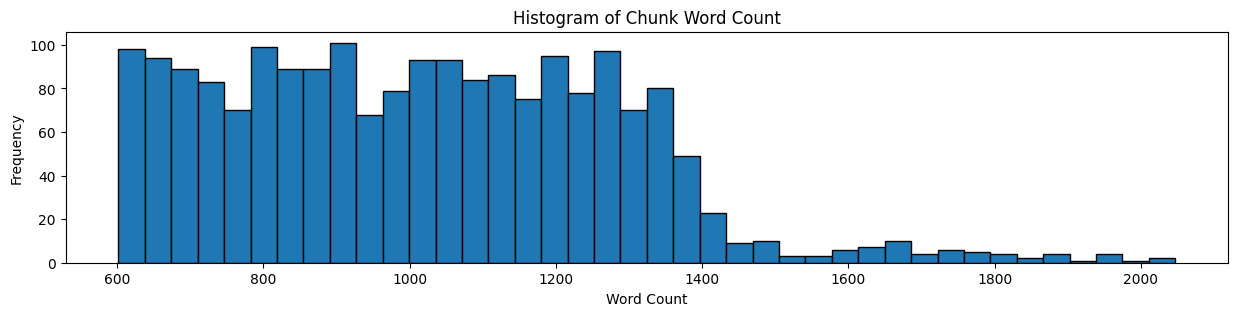

In [117]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,3))
plt.hist(df_chunks['Chunk_Words'], bins=40, edgecolor='k') 
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Histogram of Chunk Word Count')
plt.show()

In [121]:
df_chunks.loc[:,'Approx_Ques'] = (df_chunks['Chunk_Words']/280).apply(round)

In [122]:
df_chunks

,Section_Id,Chunk_Id,Chunk,Chunk_Letters,Chunk_Words,Chunk_Approx_Tokens,Approx_Ques
1,Book01_002,1,THE MAHABHARATA ADI PARVA Section I\nOm! Havin...,7511,1214,1615.0,4
2,Book01_002,2,The Rishi Vyasa published this mass of knowled...,7551,1261,1677.0,5
3,Book01_002,3,"Vyasa executed the compilation of the Bharata,...",6986,1162,1545.0,4
5,Book01_002,5,'When I heard that Yudhishthira had been follo...,10832,1949,2592.0,7
6,Book01_002,6,"'Alas! Gandhari, destitute of children, grand-...",7755,1246,1657.0,4
...,...,...,...,...,...,...,...
2826,Book18_003,2826,"3\nVaishampayana said, ""King Yudhishthira the ...",6670,1164,1548.0,4
2827,Book18_004,2827,"4\nVaishampayana said, ""King Yudhishthira, thu...",3515,608,809.0,2
2828,Book18_005,2828,"5\nJanamejaya said, ""Bhishma and Drona, those ...",7625,1258,1673.0,4
2830,Book18_006,2830,"6\nJanamejaya said, ""O holy one, according to ...",7278,1229,1635.0,4


In [123]:
df_chunks.shape

(1963, 7)

In [124]:
df_chunks.to_csv(datapath+'03-Chunked_Book.csv',index=None)

In [125]:
df = pd.read_csv(datapath+'03-Chunked_Book.csv')
df.head(3)

,Section_Id,Chunk_Id,Chunk,Chunk_Letters,Chunk_Words,Chunk_Approx_Tokens,Approx_Ques
0,Book01_002,1,THE MAHABHARATA ADI PARVA Section I\nOm! Havin...,7511,1214,1615.0,4
1,Book01_002,2,The Rishi Vyasa published this mass of knowled...,7551,1261,1677.0,5
2,Book01_002,3,"Vyasa executed the compilation of the Bharata,...",6986,1162,1545.0,4


In [126]:
len(df['Chunk'][0])

7511